# SMS Spam Classification using Multinomial Naive Bayes

In this project, we will create two models based on Multinomial NB. 
First model will classify using the standard formula for Multinomial Naive Bayes.
The second model will take in account the length of documents as fefatures, since length have a visible effect on class (Spam or Ham) as shown in the graph you will see shortly.

```P(cl|doc,len) = (P(doc,len|cl) * P(cl)) / P(doc,len)
              = (P(doc|cl) * P(len|cl) * P(cl)) / (P(doc) * P(len))
              = (P(doc|cl) * P(cl)) / P(doc) * P(len|cl) / P(len)
              = P(cl|doc) * P(len|cl) / P(len)```

In [31]:
# Importing Necessary Modules

import pandas as pd
import string
from nltk.corpus import stopwords
import collections
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re

### Reading Data

We will read the raw text file and store the data in an organized way into a csv. We will create a column SPAM. Inside the SPAM column, 1 denotes that the document is spam, 0 denotes it is not spam.

In [50]:
data_file = 'SMSSpamCollection.txt'

with open(data_file,'r') as f:
    csv_file = open("data.csv", "w+") 
    columnTitleRow = "SMS,SPAM\n"
    csv_file.write(columnTitleRow)
    counter = 0
    spamCounter = 0
    hamCounter = 0
    for line in f:
        counter+=1
        if counter%500==0:
            print(counter," Rows Written")
        if 'spam' in line[:4]:
            line = line[4:]
            t=1
            spamCounter+=1
        else:
            line = line[3:]
            t=0
            hamCounter+=1
        row = line.replace("\n","").replace(",","").replace("\t","") + "," + str(t) + "\n"
        csv_file.write(row)
csv_file.close()

print("Total Spam SMS: ",spamCounter)
print("Total Ham SMS: ",hamCounter)

500  Rows Written
1000  Rows Written
1500  Rows Written
2000  Rows Written
2500  Rows Written
3000  Rows Written
3500  Rows Written
4000  Rows Written
4500  Rows Written
5000  Rows Written
5500  Rows Written
Total Spam SMS:  747
Total Ham SMS:  4827


### Loading Dataset 

Now let's load data into dataframe from the csv we created above

In [9]:
df = pd.read_csv('data.csv')
print(df.head())

                                                 SMS  SPAM
0  Go until jurong point crazy.. Available only i...     0
1                      Ok lar... Joking wif u oni...     0
2  Free entry in 2 a wkly comp to win FA Cup fina...     1
3  U dun say so early hor... U c already then say...     0
4  Nah I don't think he goes to usf he lives arou...     0


##### Declaring some variables that will be used in calculating the probabilities

In [51]:
data_info = df.groupby('SPAM').size()
TOTAL_SPAM = data_info[1]
TOTAL_HAM = data_info[0]
PRIOR_SPAM = TOTAL_SPAM/(TOTAL_SPAM + TOTAL_HAM)
PRIOR_HAM = TOTAL_HAM/(TOTAL_SPAM + TOTAL_HAM)

### Extracting New Feature

Creating a new feature LENGTH, which will be used in another model to demonstrate the improvement in accuracy.

In [11]:
df['LENGTH'] = df['SMS'].apply(len)
print(df.head())
print("\n")
print("Max length of HAM: ",df[(df['SPAM']==0)].LENGTH.max())
print("Max length of SPAM: ",df[(df['SPAM']==1)].LENGTH.max())

                                                 SMS  SPAM  LENGTH
0  Go until jurong point crazy.. Available only i...     0     110
1                      Ok lar... Joking wif u oni...     0      29
2  Free entry in 2 a wkly comp to win FA Cup fina...     1     155
3  U dun say so early hor... U c already then say...     0      49
4  Nah I don't think he goes to usf he lives arou...     0      60


Max length of HAM:  910
Max length of SPAM:  222


It can be clearly seen that for spam sms, the length is not more than 200. For Hams, the legth goes upto 910

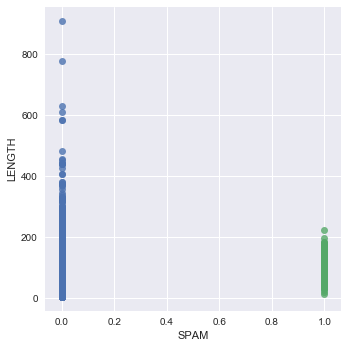

In [7]:
sns.lmplot( x="SPAM", y="LENGTH", data=df, fit_reg=False, hue='SPAM', legend=False)
sns.plt.show()

In [38]:
len(training_df[(training_df['SMS'].str.contains(r'\ben\b'))].index)
training_df[(training_df['SMS'].str.contains(r'\ben\b'))]

,SMS,SPAM,LENGTH
2101,Oh Howda gud gud.. Mathe en samachara chikku:-),0,47


### Removing Punctuation and building Vocab

In [13]:
## Removing punctuation
t = [''.join(c for c in s if c not in string.punctuation) for s in df['SMS'].values.flatten()]
# Building vocab and removing stop words
vocab = collections.Counter([y for x in t for y in x.split(" ") if y.lower() not in stopwords.words('english')])

In [14]:
# Most Frequent terms and their frequency
vocab.most_common(10)

[('', 1871),
 ('u', 786),
 ('2', 482),
 ('call', 392),
 ('U', 346),
 ('get', 335),
 ('Im', 313),
 ('ur', 297),
 ('4', 293),
 ('ltgt', 276)]

In [15]:
V = len(vocab)

### Splitting data into Training and Validation sets.

In [42]:
validation_df = df.iloc[:200]
training_df = df.iloc[200:]

In [43]:
# Calculating terms in spam and ham

terms_in_spam = terms_in_ham = 0
for index, row in training_df.iterrows():
    if row['SPAM']==1:
        terms_in_spam += len(row['SMS'].split(" "))
    elif row['SPAM']==0:
        terms_in_ham += len(row['SMS'].split(" "))
print(terms_in_spam, terms_in_ham)

17051 67087


# BASIC MULTINOMIAL NB CLASSIFIER

We were able to achieve accuracy of 87.8% using the standard Multiomial NB classification.

In [44]:
def single_predict(sms):
    sms = [''.join(c for c in s if c not in string.punctuation) for s in sms]
    sms = ''.join(sms).split(" ")
    spam_prob = PRIOR_SPAM
    ham_prob = PRIOR_HAM
    terms_in_spam = terms_in_ham = 0
    flag = 0
    for term in sms:
        term = r'\b'+term+'\b'
        spam_count = ham_count = 0
        for index, row in training_df[(training_df['SMS'].str.contains(term))].iterrows():
            
            if row['SPAM']==1:
                spam_count+=1
                
            else:
                ham_count+=1

    spam_prob = spam_prob * ( (spam_count + 1) / (terms_in_spam + V) )
    ham_prob = ham_prob * ( (ham_count + 1) / (terms_in_ham + V) )
                
    if spam_prob>ham_prob:
        return 1
    else:
        return 0


In [45]:
def Standard_NB_Classifier(df):
    total = 0
    correct = 0
    correct_spam = 0
    correct_ham = 0
    for index, row in df.iterrows():
        if single_predict(row['SMS'])==row['SPAM']:
            correct+=1
            if row['SPAM'] == 1:
                correct_spam = correct_spam+1
            else:
                correct_ham = correct_ham+1
        total+=1
        if(total%50==0):
            print("Querries Processed: ",total)
            
    print("Accuracy: ",(correct/total)*100,"%")
    print("Correct Predictions: ",correct,"/",len(df.index))
            
    data_info = df.groupby('SPAM').size()
    TOTAL_SPAM = data_info[1]
    TOTAL_HAM = data_info[0]    
    
    print("Confusion Matrix")
    print("[",correct_spam,TOTAL_SPAM,"]\n[",correct_ham,TOTAL_HAM,"]")
    

In [46]:
Standard_NB_Classifier(validation_df)

Querries Processed:  50
Querries Processed:  100
Querries Processed:  150
Querries Processed:  200
Accuracy:  83.5 %
Correct Predictions:  167 / 200
Confusion Matrix
[ 0 33 ]
[ 167 167 ]


### MULTINOMIAL NB USING LENGTH AS A FEATURE

We were able to increase the accuracy upto 89% by using length of documents as a feature.

In [226]:
def single_predict_improved(sms):
    sms = [''.join(c for c in s if c not in string.punctuation) for s in sms]
    sms = ''.join(sms).split(" ")
    avg_length_spam = 0
    avg_length_ham = 0
    spam_prob = PRIOR_SPAM
    ham_prob = PRIOR_HAM
    terms_in_spam = terms_in_ham = 0
    flag = 0
    for term in sms:
        term = " "+term+" "
        spam_count = ham_count = 0
        for index, row in training_df[(training_df['SMS'].str.contains(term))].iterrows():
            if row['SPAM']==1:
                spam_count+=1
                avg_length_spam = avg_length_spam + row['LENGTH']
            else:
                ham_count+=1
                avg_length_ham = avg_length_ham + row['LENGTH']
                
    avg_length_spam = avg_length_spam / len(training_df[(training_df['SPAM']==1)].index)
    avg_length_ham = avg_length_ham / len(training_df[(training_df['SPAM']==0)].index)
    spam_prob = (spam_prob * ( (spam_count + 1) / (terms_in_spam + V) )) * ((avg_length_spam + 1) / (len(sms) + 1))
    ham_prob = (ham_prob * ( (ham_count + 1) / (terms_in_ham + V) )) * ((avg_length_ham + 1) / (len(sms) + 1))
             
#     print(avg_length_spam,avg_length_ham)
#     print(spam_prob,ham_prob)
    if spam_prob>ham_prob:
        return 1
    else:
        return 0

In [227]:
def Improved_NB_Classifier(df):
    total = 0
    correct = 0
    correct_spam = 0
    correct_ham = 0
    for index, row in df.iterrows():
        if single_predict_improved(row['SMS'])==row['SPAM']:
            correct+=1
            if row['SPAM'] == 1:
                correct_spam = correct_spam+1
            else:
                correct_ham = correct_ham+1
        total+=1
        if(total%50==0):
            print("Querries Processed: ",total)
            
    print("Accuracy: ",(correct/total)*100,"%")
    print("Correct Predictions: ",correct,"/",len(df.index))
            
    data_info = df.groupby('SPAM').size()
    TOTAL_SPAM = data_info[1]
    TOTAL_HAM = data_info[0]    
    
    print("Confusion Matrix")
    print("[",correct_spam,TOTAL_SPAM,"]\n[",correct_ham,TOTAL_HAM,"]")

In [228]:
Improved_NB_Classifier(validation_df)

Querries Processed:  50
Querries Processed:  100
Querries Processed:  150
Querries Processed:  200
Querries Processed:  250
Querries Processed:  300
Querries Processed:  350
Querries Processed:  400
Querries Processed:  450
Querries Processed:  500
Accuracy:  89.0 %
Correct Predictions:  445 / 500
Confusion Matrix
[ 18 71 ]
[ 427 429 ]
